In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import s2sphere as s2
import matplotlib.pyplot as plt
import haversine
import pickle
from sklearn.model_selection import train_test_split

In [2]:
dset = 'sandy' # one of : sandy, all, harvey
n_bins = 4 

In [3]:
def get_s2cell(lat, long, level):
    generator_obj = s2.CellId().from_lat_lng(s2.LatLng.from_degrees(lat, long)).parent(level)
    token = generator_obj.to_token()
    lat = generator_obj.to_lat_lng().lat().degrees
    lng = generator_obj.to_lat_lng().lng().degrees
    return (token, lat, lng)
get_s2cells = lambda df, level=14: pd.DataFrame(df.apply(lambda row: get_s2cell(row['lat_x'], row['lon_x'], level), axis=1).tolist(), columns=['token', 'slat', 'slng'])

norm = lambda df : la.norm(df.values, axis=1)



In [4]:
all_tweets = pd.read_pickle(f"../data/pickles/{dset}/cleanmoji.pkl")#.head(1000)
all_tweets['created_at_date'] = pd.to_datetime(all_tweets['created_at'], infer_datetime_format=True)
all_tweets = all_tweets.merge(get_s2cells(all_tweets), left_index=True, right_index=True)
all_tweets.set_index('created_at_date', inplace=True)
plot = all_tweets.resample('1H').mean()[['slat', 'slng', 'Sent_1']]
track = pd.read_pickle("../data/pickles/track.pkl")
track['TIME_'] = track['TIME_'].dt.tz_localize("UTC")
track = track[['TIME_', 'LAT', 'LON', 'INTENSITY']]#.set_index("TIME_")
us_tweets = all_tweets[all_tweets['cc'] == "US"]
all_tweets['cc'].unique(), all_tweets.columns


(array(['US', 'IE', 'DO', 'BS', 'AR', 'AU', 'PR', 'NL', 'MX', 'GB', 'GH',
        'CA', 'HT', 'BR', 'ES', 'JM', 'GN', 'KY', 'DE', 'FR', 'ID', 'HN',
        'TH', 'CL', 'PE', 'CR', 'PA', 'PH', 'CO', 'MY', 'SE', 'BD', 'CH',
        'GP', 'ZA', 'GR', 'VE', 'VI', 'NG', 'SA', 'IN', 'JP', 'BE', 'PT',
        'CN', 'BB', 'LK', 'LB', 'DK', 'VN', 'IT'], dtype=object),
 Index(['full_text', 'created_at', 'id', 'lon_x', 'lat_x', 'lat_y', 'lon_y',
        'name', 'admin1', 'admin2', 'cc', 'Text', 'Top5%', 'Emoji_1', 'Emoji_2',
        'Emoji_3', 'Emoji_4', 'Emoji_5', 'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4',
        'Pct_5', 'Sent_1', 'Sent_2', 'Sent_3', 'Sent_4', 'Sent_5', 'token',
        'slat', 'slng'],
       dtype='object'))

In [5]:
sandy_tweets = pd.merge_asof(all_tweets.sort_index().reset_index(), track, left_on='created_at_date', right_on='TIME_', direction='nearest')
sandy_tweets.shape



(79681, 36)

In [6]:
train = sandy_tweets[['created_at_date', 'full_text', 'LAT', 'LON', 'lat_x', 'lon_x'] + [f'Sent_{i+1}' for i in range(5)]]
train['dist'] = haversine.haversine_vector(train[['lat_x', 'lon_x']].values, train[['LAT', 'LON']].values, unit='km')

In [7]:
train = train.rename({
    'created_at_date' : 'date',
    'full_text' : 'text',
    'LAT' : 'hlat',
    'LON' : 'hlon',
    'lat_x' : 'tlat',
    'lon_x' : 'tlon',
    'Sent_1' : 'sent',
}, axis='columns')[['date', 'text', 'hlat', 'hlon', 'tlat', 'tlon', 'sent', 'dist']]

<AxesSubplot:>

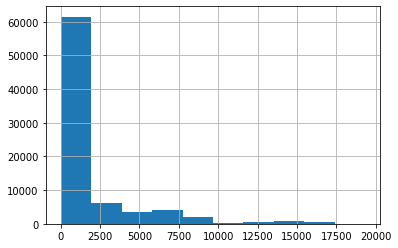

In [8]:
train['dist'].hist()

In [9]:

train['label'], dists = pd.cut(train['dist'], bins=n_bins, labels=[i for i in range(n_bins)],retbins=True, precision=1)
dists

array([  -19.33943879,  4834.85969873,  9669.71939747, 14504.5790962 ,
       19339.43879494])

In [10]:
train.to_pickle(f"../data/pickles/{dset}/train.pkl", protocol=4)

In [11]:
train.head()

,date,text,hlat,hlon,tlat,tlon,sent,dist,label
0,2012-10-25 19:18:02+00:00,So there's going to be a hurricane tonight and...,23.3,-75.3,26.844194,-80.062265,-0.299,620.665839,0
1,2012-10-25 19:18:42+00:00,They named the hurricane that will be coming u...,23.3,-75.3,40.618274,-74.549170,0.018,1926.987537,0
2,2012-10-25 19:18:46+00:00,@Pototo_28 LMFAO!!!! I'm quite jealous that a...,23.3,-75.3,25.870439,-80.327574,-0.093,583.116175,0
3,2012-10-25 19:19:06+00:00,So we're suppose to get a hurricane Monday...,23.3,-75.3,40.912246,-72.901798,0.018,1971.155149,0
4,2012-10-25 19:19:36+00:00,I'm pumped for this hurricane,23.3,-75.3,40.855067,-74.100116,-0.534,1955.252072,0


In [13]:
texts = train['text'].tolist()
info = [{'label' : label} for label in train['label']]
dflen = train.shape[0]
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(texts, info, range(dflen), test_size=0.33, random_state=42)

val_ind = i_test
test_ind = []
train_ind = i_train

train_data =  { 'info': info,
                'texts': texts,
                'train_ind': train_ind,
                'test_ind': test_ind,
                'val_ind': val_ind,
                }

with open(f"../data/pickles/{dset}/trainloader_{n_bins}.pkl", 'wb') as handle:
    pickle.dump(train_data, handle, protocol=4)
